In [1]:
# %load data_divide - ic.py
import random
import numpy as np
from tqdm import trange


fold=10

dr_pre=np.loadtxt("./source_data/e4_admat_dgc.txt").T
simdr=np.loadtxt("./source_data/e_simmat_drug.txt")
simpre=np.loadtxt("./source_data/e_simmat_target.txt")


prenum=len(simpre)

dd_dim1=dr_pre.flatten()

i=0
list_1=[]
while i<len(dd_dim1):
    if dd_dim1[i]==1:
        list_1.append(i)
    i=i+1
num1=len(list_1)
group_size1=int(num1/fold)
random.seed(10)
random.shuffle(list_1)
#
array_1=np.array(list_1)[0:fold*group_size1]
group_data1=np.reshape(array_1,(fold,group_size1))
np.savetxt("./dataset/index_1.txt",group_data1)


i=0
list_0=[]
while i<len(dd_dim1):
    if dd_dim1[i]==0:
        list_0.append(i)
    i=i+1
num0=len(list_0)
group_size0=int(num0/fold)
random.seed(10)
random.shuffle(list_0)

array_0=np.array(list_0)[0:fold*group_size0]
group_data0=np.reshape(array_0,(fold,group_size0))
np.savetxt("./dataset/index_0.txt",group_data0)


f = 0
for f in trange(fold):
    DTI = np.copy(dr_pre)
    i=0
    while i < group_size1:
        r = int(group_data1[f, i] / prenum)
        c = int(group_data1[f, i] % prenum)
        DTI[r, c] = 0
        i += 1  # 得到每次交叉验证中所使用的A矩阵
    np.savetxt("./dataset/DTI"+str(f)+".txt",DTI)





100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26it/s]


In [2]:
# %load run_main.py
import numpy as np
from function import *
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
#dr_dis=np.loadtxt("./source_data/mat_drug_disease.txt")
dr_pre=np.loadtxt("./source_data/e4_admat_dgc.txt").T
#pre_dis=np.loadtxt("./source_data/mat_protein_disease.txt")
#dr_dr=np.loadtxt("./source_data/mat_drug_drug.txt")
#dr_se=np.loadtxt("./source_data/mat_drug_se.txt")
#pre_pre=np.loadtxt("./source_data/mat_protein_protein.txt")
simdr=np.loadtxt("./source_data/e_simmat_drug.txt")
simpre=np.loadtxt("./source_data/e_simmat_target.txt")

drnum=len(simdr)
#disnum=len(dr_dis[0])
prenum=len(simpre)

index_1 = np.loadtxt("./dataset/index_1.txt")
index_0 = np.loadtxt("./dataset/index_0.txt")
index = np.hstack((index_1, index_0))
reala=dr_pre
sr = simdr
sd = simpre

RR=np.zeros(dr_pre.shape)
#A = np.hstack((dr_dr, dr_dis, dr_se))
#B = np.hstack((pre_pre, pre_dis))
#cutdr_dis = SVD(A, fr)
#cutpre_dis = SVD(B, fp)
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)
pre_simdti = np.loadtxt("./source_data/S_FGS_p_E.txt")
dr_simdti = np.loadtxt("./source_data/S_FGS_d_E.txt")

srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI" + str(f) + ".txt")
    idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    for i in trange(l_2):
        R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    #for i in range(len(idx)):
        #d=int(idx[i]/prenum)
        #p=int(idx[i]%prenum)
    
        #realvalue[d,p]=reala[d,p]
    #for i in range(len(idx)):
        #d=int(idx[i]/prenum)
        #p=int(idx[i]%prenum)
        #RR[d,p]=R[d,p]

y_true_m = dr_pre.tolist()
y_pre_m = R.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]

for f in range(n_fold):
    idx=index[f,:]
    singal=[[] for i in range(len(y_true_m))]
    singal_test=[[] for i in range(len(y_true_m))]
    for i in trange(len(y_true_m)):
        for j in range(len(y_true_m[0])):
            if i*prenum+j in idx:
                singal[i].append(y_true_m[i][j])
                singal_test[i].append(y_pre_m[i][j])
    y_true=singal
    y_pre=singal_test

    idx = []
    tpr_list = []
    fpr_list = []
    recall_list = []
    precision_list = []
    c = 0
    for i in trange(len(y_true)):
        if np.sum(np.array(y_true[i])) == 0:
            c += 1
            continue
        else:
            tpr1, fpr1, precision1, recall1 = tpr_fpr_precision_recall(np.array(y_true[i]), np.array(y_pre[i]))
            fpr_list.append(fpr1)
            tpr_list.append(tpr1)
            precision_list.append(precision1)
            recall_list.append(recall1)
    coverage = []

    for i in tpr_list:
        try:
            coverage.append(i.index(1.0)+1)
        except:
            print('1')
    print(np.mean(np.array(coverage)))

    tpr = equal_len_list(tpr_list)
    print(len(tpr ),type(tpr))
    fpr = equal_len_list(fpr_list)
    precision = equal_len_list(precision_list)
    recall = equal_len_list(recall_list)
    tpr_mean = np.mean(tpr, axis=0)
    tpr_cov[f]=tpr_mean
    print(type(tpr_mean),len(tpr_mean))
    fpr_mean = np.mean(fpr, axis=0)
    fpr_cov[f]=fpr_mean
    recall_mean = np.mean(recall, axis=0)
    recall_cov[f]=recall_mean
    precision_mean = np.mean(precision, axis=0)
    precision_cov[f]=precision_mean
    print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean, tpr_mean))
    print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean, precision_mean)+recall_mean[0]*precision_mean[0])

tpr = equal_len_list(tpr_cov)
fpr = equal_len_list(fpr_cov)
precision = equal_len_list(precision_cov)
recall = equal_len_list(recall_cov)

tpr_mean = np.mean(tpr, axis=0)
fpr_mean = np.mean(fpr, axis=0)
recall_mean = np.mean(recall, axis=0)
precision_mean = np.mean(precision, axis=0)

print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean, tpr_mean))
print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean, precision_mean)+recall_mean[0]*precision_mean[0])

np.savetxt('./result/fpr_list.txt', fpr_mean)
np.savetxt('./result/tpr_list.txt', tpr_mean)
np.savetxt('./result/recall_list.txt', recall_mean)
np.savetxt('./result/precision_list.txt', precision_mean)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.87it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.06it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 1949.93it/s]


2.2641509433962264
212 <class 'list'>
<class 'numpy.ndarray'> 40
The auc of prediction is: 0.995223618979642
The aupr of prediction is: 0.9161667829463358


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 2117.50it/s]


2.318840579710145
207 <class 'list'>
<class 'numpy.ndarray'> 49
The auc of prediction is: 0.9950118347382857
The aupr of prediction is: 0.9132959476396337


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 2020.65it/s]


2.191780821917808
219 <class 'list'>
<class 'numpy.ndarray'> 48
The auc of prediction is: 0.9951559341882741
The aupr of prediction is: 0.9179099744845782


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 2090.72it/s]


2.2429906542056073
214 <class 'list'>
<class 'numpy.ndarray'> 51
The auc of prediction is: 0.9951882322658813
The aupr of prediction is: 0.9158542401536267


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 2069.63it/s]


2.2748815165876777
211 <class 'list'>
<class 'numpy.ndarray'> 49
The auc of prediction is: 0.9953529532411557
The aupr of prediction is: 0.9158798945089694


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 1932.35it/s]


2.2429906542056073
214 <class 'list'>
<class 'numpy.ndarray'> 44
The auc of prediction is: 0.994838110837097
The aupr of prediction is: 0.9125184673152562


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 2014.21it/s]


2.2641509433962264
212 <class 'list'>
<class 'numpy.ndarray'> 47
The auc of prediction is: 0.9950933422517221
The aupr of prediction is: 0.9164187377782131


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 2074.56it/s]


2.2535211267605635
213 <class 'list'>
<class 'numpy.ndarray'> 45
The auc of prediction is: 0.9953337310433134
The aupr of prediction is: 0.9167689899491911


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 2084.06it/s]


2.2325581395348837
215 <class 'list'>
<class 'numpy.ndarray'> 47
The auc of prediction is: 0.9953153379510993
The aupr of prediction is: 0.9181276332658435


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 1984.36it/s]

7.102439024390244
205 <class 'list'>
<class 'numpy.ndarray'> 47
The auc of prediction is: 0.9493871885761719
The aupr of prediction is: 0.6426104580279846
The auc of prediction is: 0.9904886430277609
The aupr of prediction is: 0.8856277615504748


In [8]:
RR.shape

(445, 664)

In [9]:
reala.shape

(445, 664)

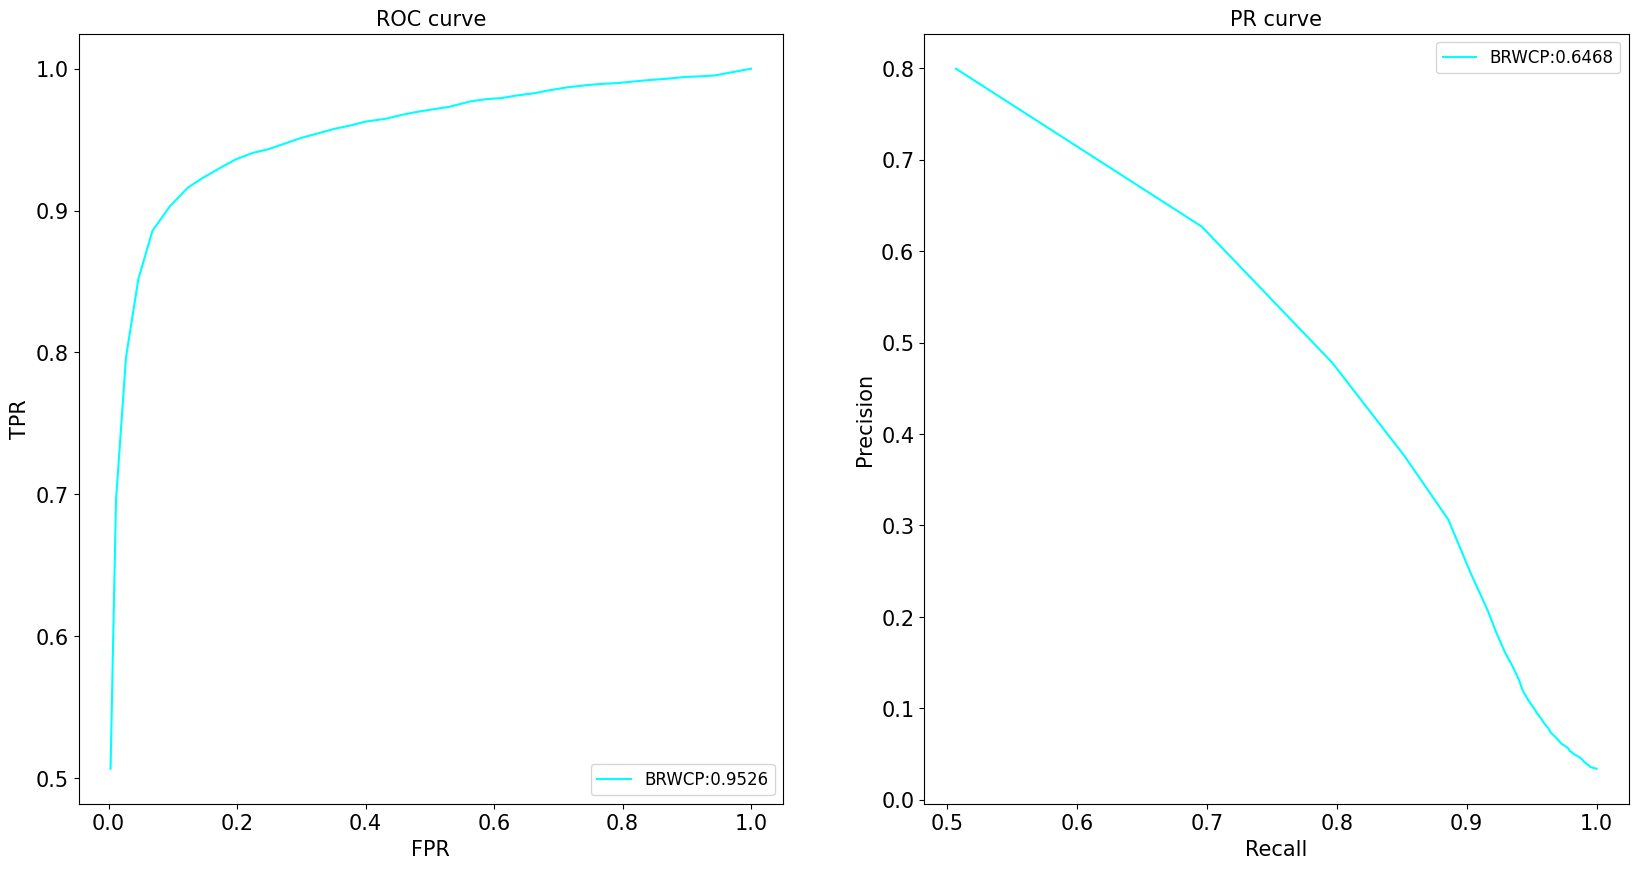

In [10]:
# %load draw_fig.py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import *
from tqdm import tqdm
import pylab as Plot

CPC_FPR = np.loadtxt('./result/fpr_list.txt')
CPC_TPR = np.loadtxt('./result/tpr_list.txt')
CPC_RECALL = np.loadtxt('./result/recall_list.txt')
CPC_P = np.loadtxt('./result/precision_list.txt')



plt.figure(1, figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.rcParams['figure.figsize'] = (4, 4)
plt.title('ROC curve', fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)


plt.plot(CPC_FPR, CPC_TPR, 'aqua', label='BRWCP:{:.4f}'.format(auc(CPC_FPR, CPC_TPR)))


plt.legend(loc='lower right', fontsize=12)
# plt.plot(fpr_mean, tpr_mean)


plt.subplot(1, 2, 2)
plt.title('PR curve', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize=15)

plt.plot(CPC_RECALL, CPC_P, 'aqua', label='BRWCP:{:.4f}'.format(auc(CPC_RECALL, CPC_P)+CPC_RECALL[0]*CPC_P[0]))


plt.legend(loc='upper right', fontsize=12)
plt.show()


# setting2

In [1]:
import random
import numpy as np
from tqdm import trange
import numpy as np

fold = 10
dr_pre=np.loadtxt("./source_data/e4_admat_dgc.txt").T
simdr=np.loadtxt("./source_data/e_simmat_drug.txt")
simpre=np.loadtxt("./source_data/e_simmat_target.txt")

prenum = len(simpre)
drnum = len(simdr)

# 获取药物的索引（矩阵的行索引）
drug_indices = list(range(dr_pre.shape[0]))
num_d = len(drug_indices)

group_size1_d = int(num_d / fold)
random.seed(10)
random.shuffle(drug_indices)

array_1=np.array(drug_indices)[0:fold*group_size1_d]
group_data1=np.reshape(array_1,(fold,group_size1_d))

f = 0
for f in trange(fold):
    DTI = np.copy(dr_pre)
    i=0
    while i < group_size1_d:
        r = group_data1[f,i ] 
        c = np.where(DTI[group_data1[f, i], :] == 1)[0]
        DTI[r, c] = 0
        i += 1  # 得到每次交叉验证中所使用的A矩阵
    np.savetxt("./dataset/DTI_setting2"+str(f)+".txt",DTI)



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53it/s]


In [2]:
# %load run_main.py
import numpy as np
from function import *
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
import time
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
dr_pre=np.loadtxt("./source_data/e4_admat_dgc.txt").T
simdr=np.loadtxt("./source_data/e_simmat_drug.txt")
simpre=np.loadtxt("./source_data/e_simmat_target.txt")

drnum=len(simdr)     #药物的数目
#disnum=len(dr_dis[0])     #副作用的数目
prenum=len(simpre)     #蛋白质的数目


#index_1 = np.loadtxt("./dataset/index_1.txt")
#index_0 = np.loadtxt("./dataset/index_0.txt")
#index = np.hstack((index_1, index_0))     #水平拼接
reala=dr_pre
sr = simdr
sd = simpre/100

RR=np.zeros(dr_pre.shape)       #原始的邻接矩阵
#A = np.hstack((dr_dr, dr_dis, dr_se))       #Fr
#B = np.hstack((pre_pre, pre_dis))         #Fp
#cutdr_dis = SVD(A, fr)    #奇异值分解    Fr'
#cutpre_dis = SVD(B, fp)     #奇异值分解    Fp'
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)    #计算余弦相似度   SrF
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)        #计算余弦相似度   SpF
pre_simdti = np.loadtxt("./source_data/S_FGS_p_E.txt")
dr_simdti = np.loadtxt("./source_data/S_FGS_d_E.txt")

# 获取药物的索引（矩阵的行索引）
drug_indices = list(range(dr_pre.shape[0]))
num_d = len(drug_indices)

group_size1_d = int(num_d / fold)
random.seed(10)
random.shuffle(drug_indices)

array_1=np.array(drug_indices)[0:fold*group_size1_d]
group_data1=np.reshape(array_1,(fold,group_size1_d))
# 获取靶点的索引（矩阵的列索引）
protein_indices = list(range(dr_pre.shape[1]))

# 记录开始时间
start_time = time.time()

srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI_setting2" + str(f) + ".txt")
    #idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    for i in trange(l_2):
        R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    for i in range(len(group_data1[f, :])): 
        d=group_data1[f, i]
        p=np.where(DTI[group_data1[f, i], :] == 1)[0]
        realvalue[d,p]=reala[d,p]
    for i in range(len(group_data1[f, :])): 
        d=group_data1[f, i]
        p=np.where(DTI[group_data1[f, i], :] == 1)[0]
        RR[d,p]=R[d,p]

y_true_m = dr_pre.tolist()
y_pre_m = RR.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]

for f in range(n_fold):
    #idx=index[f,:]
    singal=[[] for i in range(len(y_true_m))]
    singal_test=[[] for i in range(len(y_true_m))]
    for i in trange(len(y_true_m)):
        for j in range(len(y_true_m[0])):
            if i in group_data1[f, :] and j in protein_indices :
                singal[i].append(y_true_m[i][j])
                singal_test[i].append(y_pre_m[i][j])
    y_true=singal
    y_pre=singal_test

    idx = []
    tpr_list = []
    fpr_list = []
    recall_list = []
    precision_list = []
    c = 0
    for i in trange(len(y_true)):
        if np.sum(np.array(y_true[i])) == 0:
            c += 1
            continue
        else:
            tpr1, fpr1, precision1, recall1 = tpr_fpr_precision_recall(np.array(y_true[i]), np.array(y_pre[i]))
            fpr_list.append(fpr1)
            tpr_list.append(tpr1)
            precision_list.append(precision1)
            recall_list.append(recall1)
    coverage = []

    for i in tpr_list:
        try:
            coverage.append(i.index(1.0)+1)
        except:
            print('1')
    print(np.mean(np.array(coverage)))

    tpr = equal_len_list(tpr_list)
    print(len(tpr ),type(tpr))
    fpr = equal_len_list(fpr_list)
    precision = equal_len_list(precision_list)
    recall = equal_len_list(recall_list)
    tpr_mean = np.mean(tpr, axis=0)
    tpr_cov[f]=tpr_mean
    print(type(tpr_mean),len(tpr_mean))
    fpr_mean = np.mean(fpr, axis=0)
    fpr_cov[f]=fpr_mean
    recall_mean = np.mean(recall, axis=0)
    recall_cov[f]=recall_mean
    precision_mean = np.mean(precision, axis=0)
    precision_cov[f]=precision_mean
    print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean, tpr_mean))
    print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean, precision_mean)+recall_mean[0]*precision_mean[0])

tpr = equal_len_list(tpr_cov)
fpr = equal_len_list(fpr_cov)
precision = equal_len_list(precision_cov)
recall = equal_len_list(recall_cov)

tpr_mean_snf = np.mean(tpr, axis=0)
fpr_mean_snf = np.mean(fpr, axis=0)
recall_mean_snf = np.mean(recall, axis=0)
precision_mean_snf = np.mean(precision, axis=0)

# 记录结束时间并计算运行时间
end_time = time.time()
runtime = end_time - start_time

print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean_snf, tpr_mean_snf))
print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean_snf, precision_mean_snf)+recall_mean_snf[0]*precision_mean_snf[0])
# 打印灵敏度和运行时间

print('Runtime:', runtime)
#np.savetxt('./result/fpr_list_snf.txt', fpr_mean_snf)
#np.savetxt('./result/tpr_list.txt_snf', tpr_mean_snf)
#np.savetxt('./result/recall_list.txt_snf', recall_mean_snf)
#np.savetxt('./result/precision_list.txt_snf', precision_mean_snf)






100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:22<00:22,  4.52s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.59it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.55it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.55it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 617.86it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 1062.81it/s]


12.022727272727273
44 <class 'list'>
<class 'numpy.ndarray'> 664
The auc of prediction is: 0.9955769260053422
The aupr of prediction is: 0.8251628133217109


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 1035.97it/s]


16.227272727272727
44 <class 'list'>
<class 'numpy.ndarray'> 664
The auc of prediction is: 0.9936836444505086
The aupr of prediction is: 0.8183153500054307


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 1064.72it/s]


12.159090909090908
44 <class 'list'>
<class 'numpy.ndarray'> 664
The auc of prediction is: 0.9948507892699143
The aupr of prediction is: 0.8141334908263252


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 1099.82it/s]


8.363636363636363
44 <class 'list'>
<class 'numpy.ndarray'> 664
The auc of prediction is: 0.9971698224930542
The aupr of prediction is: 0.8464187134616086


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 1095.89it/s]


11.795454545454545
44 <class 'list'>
<class 'numpy.ndarray'> 664
The auc of prediction is: 0.9955381524804137
The aupr of prediction is: 0.8117579094626535


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 1086.78it/s]


10.045454545454545
44 <class 'list'>
<class 'numpy.ndarray'> 664
The auc of prediction is: 0.9957891159031271
The aupr of prediction is: 0.8257929261615651


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 1097.48it/s]


9.522727272727273
44 <class 'list'>
<class 'numpy.ndarray'> 664
The auc of prediction is: 0.9969799556326524
The aupr of prediction is: 0.8325342741590787


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 1101.58it/s]


10.409090909090908
44 <class 'list'>
<class 'numpy.ndarray'> 664
The auc of prediction is: 0.9966027803472913
The aupr of prediction is: 0.8269800120322888


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 1019.21it/s]


9.0
44 <class 'list'>
<class 'numpy.ndarray'> 664
The auc of prediction is: 0.9969814506231022
The aupr of prediction is: 0.8356209116959511


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 1053.98it/s]

474.02272727272725
44 <class 'list'>
<class 'numpy.ndarray'> 664
The auc of prediction is: 0.508532578935718
The aupr of prediction is: 0.011758560432244155
The auc of prediction is: 0.9474973456021343
The aupr of prediction is: 0.6727059120080543
Runtime: 56.777151584625244


# setting3

In [3]:
import random
import numpy as np
from tqdm import trange
import numpy as np

fold = 10
dr_pre=np.loadtxt("./source_data/e4_admat_dgc.txt").T
simdr=np.loadtxt("./source_data/e_simmat_drug.txt")
simpre=np.loadtxt("./source_data/e_simmat_target.txt")

prenum = len(simpre)
drnum = len(simdr)

# 获取药物的索引（矩阵的行索引）
drug_indices = list(range(dr_pre.shape[0]))
num_d = len(drug_indices)
group_size1_d = int(num_d / fold)
random.seed(10)
random.shuffle(drug_indices)

# 获取靶点的索引（矩阵的列索引）
protein_indices = list(range(dr_pre.shape[1]))
num_p = len(protein_indices)
group_size1_p = int(num_p / fold)
random.seed(10)
random.shuffle(protein_indices)

array_1_p=np.array(protein_indices)[0:fold*group_size1_p]
group_data1_p=np.reshape(array_1_p,(fold,group_size1_p))

f = 0
for f in trange(fold):
    DTI = np.copy(dr_pre)
    i=0
    while i < group_size1_p:
        r = np.where(dr_pre[:, group_data1_p[f, i]] == 1)[0]
        c = group_data1_p[f, i]
        DTI[r, c] = 0
        i += 1  # 得到每次交叉验证中所使用的A矩阵
    np.savetxt("./dataset/DTI_setting3"+str(f)+".txt",DTI)



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.73it/s]


In [4]:
# %load run_main.py
import numpy as np
from function import *
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
import time
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
dr_pre=np.loadtxt("./source_data/e4_admat_dgc.txt").T
simdr=np.loadtxt("./source_data/e_simmat_drug.txt")
simpre=np.loadtxt("./source_data/e_simmat_target.txt")

drnum=len(simdr)     #药物的数目
#disnum=len(dr_dis[0])     #副作用的数目
prenum=len(simpre)     #蛋白质的数目


#index_1 = np.loadtxt("./dataset/index_1.txt")
#index_0 = np.loadtxt("./dataset/index_0.txt")
#index = np.hstack((index_1, index_0))     #水平拼接
reala=dr_pre
sr = simdr
sd = simpre/100

RR=np.zeros(dr_pre.shape)       #原始的邻接矩阵
#A = np.hstack((dr_dr, dr_dis, dr_se))       #Fr
#B = np.hstack((pre_pre, pre_dis))         #Fp
#cutdr_dis = SVD(A, fr)    #奇异值分解    Fr'
#cutpre_dis = SVD(B, fp)     #奇异值分解    Fp'
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)    #计算余弦相似度   SrF
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)        #计算余弦相似度   SpF
pre_simdti = np.loadtxt("./source_data/S_FGS_p_E.txt")
dr_simdti = np.loadtxt("./source_data/S_FGS_d_E.txt")

# 获取靶点的索引（矩阵的列索引）
protein_indices = list(range(dr_pre.shape[1]))
num_p = len(protein_indices)
group_size1_p = int(num_p / fold)
random.seed(10)
random.shuffle(protein_indices)

array_1_p=np.array(protein_indices)[0:fold*group_size1_p]
group_data1_p=np.reshape(array_1_p,(fold,group_size1_p))

# 记录开始时间
start_time = time.time()

srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI_setting3" + str(f) + ".txt")
    #idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    for i in trange(l_2):
        R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    for i in range(len(group_data1_p[f, :])): 
        d=np.where(dr_pre[:, group_data1_p[f, i]] == 1)[0]
        p=group_data1_p[f, i]
        realvalue[d,p]=reala[d,p]
    for i in range(len(group_data1_p[f, :])): 
        d=np.where(dr_pre[:, group_data1_p[f, i]] == 1)[0]
        p=group_data1_p[f, i]
        RR[d,p]=R[d,p]

y_true_m = dr_pre.tolist()
y_pre_m = RR.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]

for f in range(n_fold):
    #idx=index[f,:]
    singal=[[] for i in range(len(y_true_m))]
    singal_test=[[] for i in range(len(y_true_m))]
    for i in trange(len(y_true_m)):
        for j in range(len(y_true_m[0])):
            if i in drug_indices and j in group_data1_p[f, :] :
                singal[i].append(y_true_m[i][j])
                singal_test[i].append(y_pre_m[i][j])
    y_true=singal
    y_pre=singal_test

    idx = []
    tpr_list = []
    fpr_list = []
    recall_list = []
    precision_list = []
    c = 0
    for i in trange(len(y_true)):
        if np.sum(np.array(y_true[i])) == 0:
            c += 1
            continue
        else:
            tpr1, fpr1, precision1, recall1 = tpr_fpr_precision_recall(np.array(y_true[i]), np.array(y_pre[i]))
            fpr_list.append(fpr1)
            tpr_list.append(tpr1)
            precision_list.append(precision1)
            recall_list.append(recall1)
    coverage = []

    for i in tpr_list:
        try:
            coverage.append(i.index(1.0)+1)
        except:
            print('1')
    print(np.mean(np.array(coverage)))

    tpr = equal_len_list(tpr_list)
    print(len(tpr ),type(tpr))
    fpr = equal_len_list(fpr_list)
    precision = equal_len_list(precision_list)
    recall = equal_len_list(recall_list)
    tpr_mean = np.mean(tpr, axis=0)
    tpr_cov[f]=tpr_mean
    print(type(tpr_mean),len(tpr_mean))
    fpr_mean = np.mean(fpr, axis=0)
    fpr_cov[f]=fpr_mean
    recall_mean = np.mean(recall, axis=0)
    recall_cov[f]=recall_mean
    precision_mean = np.mean(precision, axis=0)
    precision_cov[f]=precision_mean
    print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean, tpr_mean))
    print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean, precision_mean)+recall_mean[0]*precision_mean[0])

tpr = equal_len_list(tpr_cov)
fpr = equal_len_list(fpr_cov)
precision = equal_len_list(precision_cov)
recall = equal_len_list(recall_cov)

tpr_mean_snf = np.mean(tpr, axis=0)
fpr_mean_snf = np.mean(fpr, axis=0)
recall_mean_snf = np.mean(recall, axis=0)
precision_mean_snf = np.mean(precision, axis=0)

# 记录结束时间并计算运行时间
end_time = time.time()
runtime = end_time - start_time

print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean_snf, tpr_mean_snf))
print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean_snf, precision_mean_snf)+recall_mean_snf[0]*precision_mean_snf[0])
# 打印灵敏度和运行时间

print('Runtime:', runtime)
#np.savetxt('./result/fpr_list_snf.txt', fpr_mean_snf)
#np.savetxt('./result/tpr_list.txt_snf', tpr_mean_snf)
#np.savetxt('./result/recall_list.txt_snf', recall_mean_snf)
#np.savetxt('./result/precision_list.txt_snf', precision_mean_snf)






100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.58it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:22<00:22,  4.52s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.58it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 445/445 [00:01<00:00, 365.06it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 1857.25it/s]


1.7611336032388665
247 <class 'list'>
<class 'numpy.ndarray'> 66
The auc of prediction is: 0.9968685619997113
The aupr of prediction is: 0.9361765129472923


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 1978.68it/s]


1.9465020576131686
243 <class 'list'>
<class 'numpy.ndarray'> 66
The auc of prediction is: 0.996697218122493
The aupr of prediction is: 0.9320562071353766


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 1681.42it/s]


2.138047138047138
297 <class 'list'>
<class 'numpy.ndarray'> 66
The auc of prediction is: 0.9961215214833627
The aupr of prediction is: 0.9235979580128699


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 2695.49it/s]


2.452127659574468
188 <class 'list'>
<class 'numpy.ndarray'> 66
The auc of prediction is: 0.9940709316370975
The aupr of prediction is: 0.9074377350832374


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 1662.38it/s]


2.193548387096774
279 <class 'list'>
<class 'numpy.ndarray'> 66
The auc of prediction is: 0.9953691904481136
The aupr of prediction is: 0.9183900079069249


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 2867.83it/s]


2.683333333333333
180 <class 'list'>
<class 'numpy.ndarray'> 66
The auc of prediction is: 0.9942187391935157
The aupr of prediction is: 0.9042466455502819


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 3084.01it/s]


2.2738095238095237
168 <class 'list'>
<class 'numpy.ndarray'> 66
The auc of prediction is: 0.9944830886905415
The aupr of prediction is: 0.9052204800204728


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 2710.97it/s]


2.6476683937823835
193 <class 'list'>
<class 'numpy.ndarray'> 66
The auc of prediction is: 0.9938025622794056
The aupr of prediction is: 0.9027625104860924


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 2228.22it/s]


2.2336448598130842
214 <class 'list'>
<class 'numpy.ndarray'> 66
The auc of prediction is: 0.9954795812849643
The aupr of prediction is: 0.9197239352476057


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 3917.34it/s]

2.3893129770992365
131 <class 'list'>
<class 'numpy.ndarray'> 66
The auc of prediction is: 0.9947553084434342
The aupr of prediction is: 0.9099896769305396
The auc of prediction is: 0.9950986151926284
The aupr of prediction is: 0.9143271786981556
Runtime: 59.491127014160156


# setting4

In [5]:
import random
import numpy as np
from tqdm import trange
import numpy as np

fold = 10
dr_pre=np.loadtxt("./source_data/e4_admat_dgc.txt").T
simdr=np.loadtxt("./source_data/e_simmat_drug.txt")
simpre=np.loadtxt("./source_data/e_simmat_target.txt")

prenum = len(simpre)
drnum = len(simdr)

# 获取药物的索引（矩阵的行索引）
drug_indices = list(range(dr_pre.shape[0]))
num_d = len(drug_indices)
group_size1_d = int(num_d / fold)
random.seed(10)
random.shuffle(drug_indices)

# 获取靶点的索引（矩阵的列索引）
protein_indices = list(range(dr_pre.shape[1]))
num_p = len(protein_indices)
group_size1_p = int(num_p / fold)
random.seed(10)
random.shuffle(protein_indices)

array_1_p=np.array(protein_indices)[0:fold*group_size1_p]
group_data1_p=np.reshape(array_1_p,(fold,group_size1_p))

f = 0
for f in trange(fold):
    DTI = np.copy(dr_pre)
    i=0
    while i < group_size1_d:
        r = group_data1[f,i ] 
        c = np.where(DTI[group_data1[f, i], :] == 1)[0]
        DTI[r, c] = 0
        i += 1  # 得到每次交叉验证中所使用的A矩阵

    while i < group_size1_p:
        r = np.where(dr_pre[:, group_data1_p[f, i]] == 1)[0]
        c = group_data1_p[f, i]
        DTI[r, c] = 0
        i += 1  # 得到每次交叉验证中所使用的A矩阵
    np.savetxt("./dataset/DTI_setting4"+str(f)+".txt",DTI)



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.67it/s]


In [6]:
# %load run_main.py
import numpy as np
from function import *
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
import time
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
dr_pre=np.loadtxt("./source_data/e4_admat_dgc.txt").T
simdr=np.loadtxt("./source_data/e_simmat_drug.txt")
simpre=np.loadtxt("./source_data/e_simmat_target.txt")

drnum=len(simdr)     #药物的数目
#disnum=len(dr_dis[0])     #副作用的数目
prenum=len(simpre)     #蛋白质的数目


#index_1 = np.loadtxt("./dataset/index_1.txt")
#index_0 = np.loadtxt("./dataset/index_0.txt")
#index = np.hstack((index_1, index_0))     #水平拼接
reala=dr_pre
sr = simdr
sd = simpre/100

RR=np.zeros(dr_pre.shape)       #原始的邻接矩阵
RR_1=np.zeros(dr_pre.shape)       #原始的邻接矩阵
#A = np.hstack((dr_dr, dr_dis, dr_se))       #Fr
#B = np.hstack((pre_pre, pre_dis))         #Fp
#cutdr_dis = SVD(A, fr)    #奇异值分解    Fr'
#cutpre_dis = SVD(B, fp)     #奇异值分解    Fp'
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)    #计算余弦相似度   SrF
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)        #计算余弦相似度   SpF
pre_simdti = np.loadtxt("./source_data/S_FGS_p_E.txt")
dr_simdti = np.loadtxt("./source_data/S_FGS_d_E.txt")

# 获取药物的索引（矩阵的行索引）
drug_indices = list(range(dr_pre.shape[0]))
num_d = len(drug_indices)
group_size1_d = int(num_d / fold)
random.seed(10)
random.shuffle(drug_indices)
array_1=np.array(drug_indices)[0:fold*group_size1_d]
group_data1=np.reshape(array_1,(fold,group_size1_d))

# 获取靶点的索引（矩阵的列索引）
protein_indices = list(range(dr_pre.shape[1]))
num_p = len(protein_indices)
group_size1_p = int(num_p / fold)
random.seed(10)
random.shuffle(protein_indices)

array_1_p=np.array(protein_indices)[0:fold*group_size1_p]
group_data1_p=np.reshape(array_1_p,(fold,group_size1_p))

# 记录开始时间
start_time = time.time()

srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI_setting4" + str(f) + ".txt")
    #idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    for i in trange(l_2):
        R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    realvalue_1=np.zeros(R.shape)
    for i in range(len(group_data1[f, :])): 
        d=group_data1[f, i]
        p=np.where(DTI[group_data1[f, i], :] == 1)[0]
        realvalue_1[d,p]=reala[d,p]
    for i in range(len(group_data1_p[f, :])): 
        d=np.where(dr_pre[:, group_data1_p[f, i]] == 1)[0]
        p=group_data1_p[f, i]
        realvalue[d,p]=realvalue_1[d,p]
    for i in range(len(group_data1[f, :])): 
        d=group_data1[f, i]
        p=np.where(DTI[group_data1[f, i], :] == 1)[0]
        RR_1[d,p]=R[d,p]
    for i in range(len(group_data1_p[f, :])): 
        d=np.where(dr_pre[:, group_data1_p[f, i]] == 1)[0]
        p=group_data1_p[f, i]
        RR[d,p]=RR_1[d,p]

    
y_true_m = dr_pre.tolist()
y_pre_m = RR.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]

for f in range(n_fold):
    #idx=index[f,:]
    singal=[[] for i in range(len(y_true_m))]
    singal_test=[[] for i in range(len(y_true_m))]
    for i in trange(len(y_true_m)):
        for j in range(len(y_true_m[0])):
            if i in drug_indices and j in group_data1_p[f, :] :
                singal[i].append(y_true_m[i][j])
                singal_test[i].append(y_pre_m[i][j])
            if i in group_data1[f, :] and j in protein_indices :
                singal[i].append(y_true_m[i][j])
                singal_test[i].append(y_pre_m[i][j])
    y_true=singal
    y_pre=singal_test

    idx = []
    tpr_list = []
    fpr_list = []
    recall_list = []
    precision_list = []
    c = 0
    for i in trange(len(y_true)):
        if np.sum(np.array(y_true[i])) == 0:
            c += 1
            continue
        else:
            tpr1, fpr1, precision1, recall1 = tpr_fpr_precision_recall(np.array(y_true[i]), np.array(y_pre[i]))
            fpr_list.append(fpr1)
            tpr_list.append(tpr1)
            precision_list.append(precision1)
            recall_list.append(recall1)
    coverage = []

    for i in tpr_list:
        try:
            coverage.append(i.index(1.0)+1)
        except:
            print('1')
    print(np.mean(np.array(coverage)))

    tpr = equal_len_list(tpr_list)
    print(len(tpr ),type(tpr))
    fpr = equal_len_list(fpr_list)
    precision = equal_len_list(precision_list)
    recall = equal_len_list(recall_list)
    tpr_mean = np.mean(tpr, axis=0)
    tpr_cov[f]=tpr_mean
    print(type(tpr_mean),len(tpr_mean))
    fpr_mean = np.mean(fpr, axis=0)
    fpr_cov[f]=fpr_mean
    recall_mean = np.mean(recall, axis=0)
    recall_cov[f]=recall_mean
    precision_mean = np.mean(precision, axis=0)
    precision_cov[f]=precision_mean
    print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean, tpr_mean))
    print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean, precision_mean)+recall_mean[0]*precision_mean[0])

tpr = equal_len_list(tpr_cov)
fpr = equal_len_list(fpr_cov)
precision = equal_len_list(precision_cov)
recall = equal_len_list(recall_cov)

tpr_mean_snf = np.mean(tpr, axis=0)
fpr_mean_snf = np.mean(fpr, axis=0)
recall_mean_snf = np.mean(recall, axis=0)
precision_mean_snf = np.mean(precision, axis=0)

# 记录结束时间并计算运行时间
end_time = time.time()
runtime = end_time - start_time

print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean_snf, tpr_mean_snf))
print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean_snf, precision_mean_snf)+recall_mean_snf[0]*precision_mean_snf[0])
# 打印灵敏度和运行时间

print('Runtime:', runtime)
#np.savetxt('./result/fpr_list_snf.txt', fpr_mean_snf)
#np.savetxt('./result/tpr_list.txt_snf', tpr_mean_snf)
#np.savetxt('./result/recall_list.txt_snf', recall_mean_snf)
#np.savetxt('./result/precision_list.txt_snf', precision_mean_snf)






100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:24<00:24,  4.96s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 445/445 [00:02<00:00, 214.96it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 607.63it/s]


33.95471698113207
265 <class 'list'>
<class 'numpy.ndarray'> 66
The auc of prediction is: 0.687952387163321
The aupr of prediction is: 0.07627989764049942


100%|███████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 663.09it/s]


78.49242424242425
264 <class 'list'>
<class 'numpy.ndarray'> 66
The auc of prediction is: 0.5588623653530543
The aupr of prediction is: 0.08903279358028818


100%|███████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 619.22it/s]


71.40894568690096
313 <class 'list'>
<class 'numpy.ndarray'> 66
The auc of prediction is: 0.6717789476941745
The aupr of prediction is: 0.12819590788604296


100%|███████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 645.14it/s]


106.41363636363636
220 <class 'list'>
<class 'numpy.ndarray'> 66
The auc of prediction is: 0.7327286041690817
The aupr of prediction is: 0.21703444720267945


100%|███████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 600.31it/s]


84.01694915254237
295 <class 'list'>
<class 'numpy.ndarray'> 66
The auc of prediction is: 0.7471927568259313
The aupr of prediction is: 0.23848807994963866


100%|███████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 670.34it/s]


108.96650717703349
209 <class 'list'>
<class 'numpy.ndarray'> 66
The auc of prediction is: 0.7621572693336123
The aupr of prediction is: 0.28443321017744416


100%|███████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 717.19it/s]


112.40609137055837
197 <class 'list'>
<class 'numpy.ndarray'> 66
The auc of prediction is: 0.793311256949455
The aupr of prediction is: 0.3634792107956783


100%|███████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 692.09it/s]


115.35348837209303
215 <class 'list'>
<class 'numpy.ndarray'> 66
The auc of prediction is: 0.821059500688786
The aupr of prediction is: 0.4599280255181952


100%|███████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 548.93it/s]


102.74583333333334
240 <class 'list'>
<class 'numpy.ndarray'> 66
The auc of prediction is: 0.8654153138156265
The aupr of prediction is: 0.5613959593520047


100%|███████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 662.53it/s]

156.41358024691357
162 <class 'list'>
<class 'numpy.ndarray'> 66
The auc of prediction is: 0.7410721625314746
The aupr of prediction is: 0.25922176912852296
The auc of prediction is: 0.7382148002038759
The aupr of prediction is: 0.24463031171656682
Runtime: 78.29125952720642
